In [76]:
import os
from datetime import datetime
import time
import threading
import json
from kafka import KafkaProducer
from kafka.errors import KafkaError
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio

In [77]:
print("tensorflow-io version: {}".format(tfio.__version__))
print("tensorflow version: {}".format(tf.__version__))

tensorflow-io version: 0.35.0
tensorflow version: 2.15.0


In [78]:
import subprocess

# Replace 'kafka-server' with the actual container name
container_name = 'kafka-server'

# Command to start Zookeeper
zookeeper_command = f'docker exec -d {container_name} /opt/bitnami/kafka/bin/zookeeper-server-start.sh /opt/bitnami/kafka/config/zookeeper.properties'
subprocess.run(zookeeper_command, shell=True)

# Command to start Kafka
kafka_command = f'docker exec -d {container_name} /opt/bitnami/kafka/bin/kafka-server-start.sh /opt/bitnami/kafka/config/server.properties'
subprocess.run(kafka_command, shell=True)

print("Waiting for 10 secs until Kafka and Zookeeper services are up and running")
subprocess.run("sleep 10", shell=True)


Waiting for 10 secs until Kafka and Zookeeper services are up and running


CompletedProcess(args='sleep 10', returncode=0)

In [79]:
import subprocess

# Command to list processes containing 'kafka'
ps_command = 'ps -ef | grep kafka'
result = subprocess.run(ps_command, shell=True, stdout=subprocess.PIPE, text=True)

# Print the result
print(result.stdout)


phan       35441   27387  0 23:13 ?        00:00:00 /bin/sh -c ps -ef | grep kafka
phan       35443   35441  0 23:13 ?        00:00:00 grep kafka



In [80]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.master('local').getOrCreate()
#sc = SparkContext().getOrCreate()
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
import pandas as pd
import numpy as np
import pickle
from pyspark.sql.functions import col, sum, expr
from pyspark.ml.feature import OneHotEncoder, StringIndexer, Tokenizer, VectorAssembler, StopWordsRemover, NGram, CountVectorizer
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LinearSVC , LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator,  BinaryClassificationEvaluator
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, NaiveBayes, NaiveBayesModel
import pyspark.sql.functions as fn
from pyspark.sql.functions import udf
from collections import Counter
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from IPython.display import HTML, display_html, display
from pyspark.mllib.evaluation import BinaryClassificationMetrics,  MulticlassMetrics

In [81]:

train_df = spark.read.csv("data/room_1/train.csv", header=True, inferSchema=True)
dev_df = spark.read.csv("data/room_1/dev.csv", header=True, inferSchema=True)
test_df = spark.read.csv("data/room_1/test.csv", header=True, inferSchema=True)

In [82]:
from pyspark.sql.functions import col


train_df = train_df.withColumn('label_id', col('label_id').cast('double'))
dev_df = dev_df.withColumn('label_id', col('label_id').cast('double'))
test_df = test_df.withColumn('label_id', col('label_id').cast('double'))

print(dev_df.filter(col('label_id').isNull()).count())


13


In [83]:
# Loại bỏ các dòng có giá trị null trong cột 'label_id'
train_df = train_df.filter(col('label_id').isNotNull())
dev_df = dev_df.filter(col('label_id').isNotNull())
test_df = test_df.filter(col('label_id').isNotNull())

In [84]:
print(dev_df.filter(col('label_id').isNull()).count())

0


In [85]:
train_df.show()

+--------------------+--------+
|           free_text|label_id|
+--------------------+--------+
|Em được làm fan c...|     0.0|
|Đúng là bọn mắt h...|     2.0|
|Đậu Văn Cường giờ...|     0.0|
|CÔN ĐỒ CỤC SÚC VÔ...|     2.0|
|Từ lý thuyết đến ...|     0.0|
|Coronavirus is ma...|     0.0|
|Đố chúng m nhận r...|     0.0|
|   Lúp lúp như chó .|     1.0|
|              🥰🥰🥰|     0.0|
|Thế mà mình nói m...|     2.0|
|Được anh ưi, lâu ...|     0.0|
|Cắt cho trẻ trâu ...|     0.0|
|Nghe rất vô lí nh...|     0.0|
|chán ghê hong có ...|     0.0|
|    Sao t gửi đc bây|     0.0|
|thế đấy. làm j bọ...|     0.0|
|Loại này cho dựa ...|     2.0|
|        Thuong wa di|     0.0|
|Dạy bơi cho cá. B...|     1.0|
|Ủa chứ bữa xin lỗ...|     2.0|
+--------------------+--------+
only showing top 20 rows



In [86]:
import matplotlib.pyplot as plt
import pandas as pd

df_train_pandas = pd.read_csv("data/room_1/train.csv")
df_dev_pandas = pd.read_csv("data/room_1/dev.csv")
df_test_pandas = pd.read_csv("data/room_1/test.csv")


df_train_pandas['Dataset'] = 'TRAIN'
df_dev_pandas['Dataset'] = 'DEV'
df_test_pandas['Dataset'] = 'TEST'

df_combined_pandas = pd.concat([df_train_pandas, df_dev_pandas, df_test_pandas],
                               ignore_index=True)


# Mapping giữa label_id và tên label
label_mapping = {0: 'CLEAN', 1: 'OFFENSIVE', 2: 'HATE'}

# Thay thế giá trị trong cột 'label_id' bằng tên tương ứng
df_combined_pandas['label_id'] = df_combined_pandas['label_id'].map(label_mapping)



In [87]:
df_combined_pandas

,free_text,label_id,Dataset
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,CLEAN,TRAIN
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,HATE,TRAIN
2,Đậu Văn Cường giờ giống thằng sida hơn à,CLEAN,TRAIN
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,HATE,TRAIN
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...,CLEAN,TRAIN
...,...,...,...
33395,Nghe cũng được. Nhưng vẫn cày views,CLEAN,TEST
33396,Pha team up căng cực đến từ vị trí ông chủ đầm...,CLEAN,TEST
33397,Thanh Nhường sao m đọc đc cmt của t thế tiên s...,CLEAN,TEST
33398,"Đúng rồi, nhìn có ria mép , với mặt giống đàn ...",CLEAN,TEST


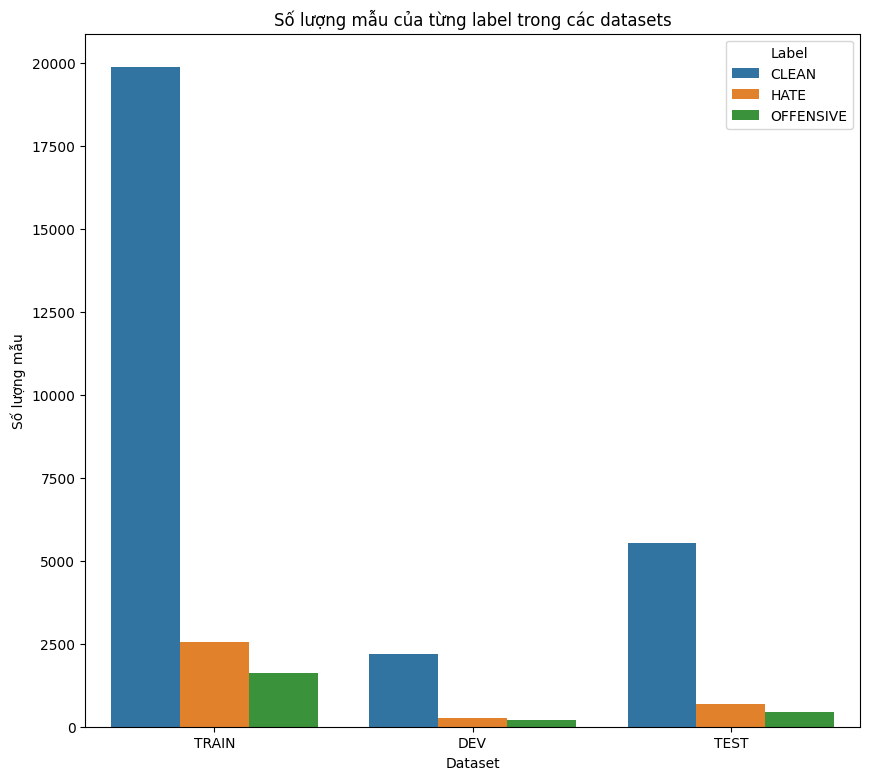

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo biểu đồ
plt.figure(figsize=(10, 9))  # Giảm kích thước của biểu đồ

# Biểu đồ stacked bar chart
sns.countplot(x='Dataset', hue='label_id', data=df_combined_pandas)

# Chỉnh lại trục x để viết hoa tên dataset và in ngang
plt.xticks([0, 1, 2], [dataset.upper() for dataset in df_combined_pandas['Dataset'].unique()])
plt.xlabel('Dataset')
plt.ylabel('Số lượng mẫu')
plt.title('Số lượng mẫu của từng label trong các datasets')
plt.legend(title='Label', loc='upper right')

# Hiển thị biểu đồ
plt.show()


In [89]:
from pyspark.sql.functions import col
from pyspark.sql import functions as fn
import regex as re

unicode_ranges = [
    u"\U0001F600-\U0001F64F",  # emoticons
    u"\U0001F300-\U0001F5FF",  # symbols & pictographs
    u"\U0001F680-\U0001F6FF",  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"   # flags (iOS)
]

# Tạo list chứa tất cả các mã Unicode
all_unicode = ''.join(unicode_ranges)

def remove_emoji(text, unicode_ranges):
    emoji_pattern = re.compile(f"[{unicode_ranges}]+", flags=re.UNICODE)
    return emoji_pattern.sub("", text)

remove_emoji_udf = fn.udf(lambda x: remove_emoji(x, all_unicode), fn.StringType())

# Áp dụng hàm UDF để loại bỏ emoji từ cột 'free_text'
df = train_df.withColumn('free_text', remove_emoji_udf('free_text'))
df.show()


+--------------------+--------+
|           free_text|label_id|
+--------------------+--------+
|Em được làm fan c...|     0.0|
|Đúng là bọn mắt h...|     2.0|
|Đậu Văn Cường giờ...|     0.0|
|CÔN ĐỒ CỤC SÚC VÔ...|     2.0|
|Từ lý thuyết đến ...|     0.0|
|Coronavirus is ma...|     0.0|
|Đố chúng m nhận r...|     0.0|
|   Lúp lúp như chó .|     1.0|
|              🥰🥰🥰|     0.0|
|Thế mà mình nói m...|     2.0|
|Được anh ưi, lâu ...|     0.0|
|Cắt cho trẻ trâu ...|     0.0|
|Nghe rất vô lí nh...|     0.0|
|chán ghê hong có ...|     0.0|
|    Sao t gửi đc bây|     0.0|
|thế đấy. làm j bọ...|     0.0|
|Loại này cho dựa ...|     2.0|
|        Thuong wa di|     0.0|
|Dạy bơi cho cá. B...|     1.0|
|Ủa chứ bữa xin lỗ...|     2.0|
+--------------------+--------+
only showing top 20 rows



In [90]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
import emoji

# Define the deEmojify function using a UDF
def deEmojify(text):
    return emoji.demojize(str(text))

# Register the UDF
deEmojify_udf = udf(deEmojify, StringType())

# Apply the UDF to the 'free_text' column
train_df = train_df.withColumn('free_text', deEmojify_udf('free_text'))

# Show the result
train_df.show()


+--------------------+--------+
|           free_text|label_id|
+--------------------+--------+
|Em được làm fan c...|     0.0|
|Đúng là bọn mắt h...|     2.0|
|Đậu Văn Cường giờ...|     0.0|
|CÔN ĐỒ CỤC SÚC VÔ...|     2.0|
|Từ lý thuyết đến ...|     0.0|
|Coronavirus is ma...|     0.0|
|Đố chúng m nhận r...|     0.0|
|   Lúp lúp như chó .|     1.0|
|:smiling_face_wit...|     0.0|
|Thế mà mình nói m...|     2.0|
|Được anh ưi, lâu ...|     0.0|
|Cắt cho trẻ trâu ...|     0.0|
|Nghe rất vô lí nh...|     0.0|
|chán ghê hong có ...|     0.0|
|    Sao t gửi đc bây|     0.0|
|thế đấy. làm j bọ...|     0.0|
|Loại này cho dựa ...|     2.0|
|        Thuong wa di|     0.0|
|Dạy bơi cho cá. B...|     1.0|
|Ủa chứ bữa xin lỗ...|     2.0|
+--------------------+--------+
only showing top 20 rows



In [91]:
from pyspark.sql.functions import col, lower, regexp_replace, pandas_udf, StringType
import regex as re
from pyspark.sql import functions as fn

emoji_list = [
    '\U0001F600', '\U0001F603', '\U0001F604', '\U0001F601', '\U0001F606', '\U0001F605', '\U0001F923',
    '\U0001F602', '\U0001F642', '\U0001F643', '\U0001FAE0', '\U0001F609', '\U0001F60A', '\U0001F607',
    '\U0001F970', '\U0001F60D', '\U0001F929', '\U0001F618', '\U0001F617', '\u263A', '\U0001F61A',
    '\U0001F619', '\U0001F972', '\U0001F60B', '\U0001F61B', '\U0001F61C', '\U0001F92A', '\U0001F61D',
    '\U0001F911', '\U0001F917', '\U0001F92D', '\U0001FAE2', '\U0001FAE3', '\U0001F92B', '\U0001F914',
    '\U0001FAE1', '\U0001F910', '\U0001F928', '\U0001F610', '\U0001F611', '\U0001F636', '\U0001FAE5',
    '\U0001F60F', '\U0001F612', '\U0001F644', '\U0001F62C', '\U0001F925', '\U0001FAE8', '\U0001F60C',
    '\U0001F614', '\U0001F62A', '\U0001F924', '\U0001F634', '\U0001F637', '\U0001F912', '\U0001F915',
    '\U0001F922', '\U0001F92E', '\U0001F927', '\U0001F975', '\U0001F976', '\U0001F974', '\U0001F635',
    '\U0001F92F', '\U0001F920', '\U0001F973', '\U0001F978', '\U0001F60E', '\U0001F913', '\U0001F9D0',
    '\U0001F615', '\U0001FAE4', '\U0001F61F', '\U0001F641', '\u2639', '\U0001F62E', '\U0001F62F',
    '\U0001F632', '\U0001F633', '\U0001F97A', '\U0001F979', '\U0001F626', '\U0001F627', '\U0001F628',
    '\U0001F630', '\U0001F625', '\U0001F622', '\U0001F62D', '\U0001F631', '\U0001F616', '\U0001F623',
    '\U0001F61E', '\U0001F613', '\U0001F629', '\U0001F62B', '\U0001F971', '\U0001F624', '\U0001F621',
    '\U0001F620', '\U0001F92C', '\U0001F608', '\U0001F47F', '\U0001F480', '\u2620', '\U0001F4A9',
    '\U0001F921', '\U0001F479', '\U0001F47A', '\U0001F47B', '\U0001F47D', '\U0001F47E', '\U0001F916',
    '\U0001F63A', '\U0001F638', '\U0001F639', '\U0001F63B', '\U0001F63C', '\U0001F63D', '\U0001F640',
    '\U0001F63F', '\U0001F63E', '\U0001F648', '\U0001F649', '\U0001F64A', '\U0001F48C', '\U0001F498',
    '\U0001F49D', '\U0001F496', '\U0001F497', '\U0001F493', '\U0001F49E', '\U0001F495', '\U0001F49F',
    '\u2763', '\U0001F494', '\u2764', '\U0001F9E1', '\U0001F49B', '\U0001F49A', '\U0001F499', '\U0001F49C'
]

def remove_emoji(text, emoji_list):
    for emoji_unicode in emoji_list:
        emoji_pattern = re.compile(f"({emoji_unicode})", flags=re.UNICODE)
        text = emoji_pattern.sub("", text)
    return text

remove_emoji_udf = fn.udf(lambda x: remove_emoji(x, emoji_list), fn.StringType())

# Áp dụng hàm UDF để loại bỏ emoji từ cột 'free_text'
train_df = train_df.withColumn('free_text', remove_emoji_udf('free_text'))



In [92]:
def clean_space(text):
    if text is None or text.isspace():
        return None  # hoặc bạn có thể trả về một giá trị mặc định khác
    else:
        return text.strip()

# Đăng ký hàm UDF
clean_text_udf = udf(clean_space, StringType())

# Áp dụng UDF cho cột free_text
train_df_cleaned = train_df.withColumn("cleaned_text", clean_text_udf(col("free_text")))

# Loại bỏ các dòng có giá trị là None trong cột cleaned_text
train_df = train_df_cleaned.dropna(subset=["cleaned_text"])


In [93]:
from pyspark.sql.types import ArrayType, StringType

def tokenize_with_pyvi(text):
    from pyvi import ViTokenizer
    return ViTokenizer.tokenize(text).split()

# Đăng ký hàm UDF
tokenize_udf = udf(tokenize_with_pyvi, ArrayType(StringType()))

# Áp dụng UDF cho cột free_text
train_df = train_df.withColumn("tokens", tokenize_udf("free_text"))

# Hiển thị kết quả
train_df.select("tokens").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------+
|tokens                                                                                                                                                     |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------+
|[Em, được, làm, fan, cứng, luôn, rồi, nè, :, red_heart, :, reaction, quá, hay, quá, cute, coi, mấy, giờ, này, quá, hợp_lí, =, ], ], ]]                     |
|[Đúng, là, bọn, mắt, híp, lò_xo, thụt, :, ), ), ), bên, việt_nam, t, cái, này, ra, cách, đây, 10, năm, r, và, bọn, t, gọi, là, cái, L, :, ), ), )]         |
|[Đậu_Văn, Cường, giờ, giống, thằng, sida, hơn, à]                                                                                                          |
|[CÔN_ĐỒ, CỤC_SÚC, VÔ, NHÂN_TÍNH, ĐỀ, NGHI, VN., NHÀ

In [94]:
train_df = train_df.withColumn("tokens_lower", udf(lambda tokens: [token.lower() for token in tokens], ArrayType(StringType()))("tokens"))


train_df = train_df.withColumn("tokens_no_punctuation", udf(lambda tokens: [token.strip(".,") for token in tokens], ArrayType(StringType()))("tokens_lower"))

def remove_special_characters(tokens):
    return [token.replace(':', '').replace('=', '').replace('[', '').replace(']', '').replace(',', '').replace(';', '').replace(')', '').replace('(', '') for token in tokens]

remove_special_characters_udf = udf(remove_special_characters, ArrayType(StringType()))

train_df = train_df.withColumn("tokens_no_special", remove_special_characters_udf("tokens_no_punctuation"))

def keep_special_tokens(tokens):
    return [token for token in tokens if any(char.isalnum() or char == '_' for char in token)]


keep_special_tokens_udf = udf(keep_special_tokens, ArrayType(StringType()))

# Áp dụng UDF cho cột tokens_no_special
train_df_cleaned = train_df.withColumn("tokens_cleaned", keep_special_tokens_udf("tokens_no_special"))

# Hiển thị kết quả
train_df_cleaned.select("tokens_no_special", "tokens_cleaned").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------+
|tokens_no_special                                                                                                                                       |tokens_cleaned                                                                                                                                    |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------+
|[em, được, làm, fan, cứng, luôn, rồi, nè, , red_heart, , reaction, quá, hay, quá, cute, coi, 

In [95]:
STOPWORDS = '/home/phan/Workspace/Bigdata_Project/vietnamese-stopwords.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)

stops = StopWordsRemover().setStopWords(stopwords).setInputCol('tokens_cleaned')\
.setOutputCol('processed_tokens')
train_df_cleaned = stops.transform(train_df_cleaned)

In [96]:
def replace_abbreviations(tokens):
    result = []
    for token in tokens:
        for full_word, abbreviations in abbreviations_dict.items():
            if token in abbreviations:
                result.append(full_word)
                break
        else:
            result.append(token)
    return result

abbreviations_dict = {
    'rồi': ['r'],
    'bạn': ['b'],
    'sao': ['s'],
    'được': ['đc'],
    'đéo': ['đ'],
    'không': ['k', 'ko', 'kh', 'kg'],
    'vãi lồn': ['vl', 'vlol'],
    'lồn': ['l', 'lol', 'lz'],
    'cái lồn má': ['clm'],
    'cặc': ['c'],
    'con cặc': ['cc'],
    'cái lồn': ['cl'],
    'vãi cả lồn': ['vcl'],
    'vãi cả cặc': ['vcc'],
    'mày': ['m'],
    "địt mẹ": ['dm', 'đm', 'đme', 'duma'],
    'anh': ['a'],
    'việt nam': ['vn', 'vnam'],
    'vậy': ['v'],
    'em': ['e'],
    'tao': ['t'],
    'con mẹ nó': ['cmn'],
    'người': ['ng'],
    'với': ['vs']
}
replace_abbreviations_udf = udf(replace_abbreviations, ArrayType(StringType()))

# Áp dụng hàm UDF cho cột tokens_clean
train_df_cleaned = train_df_cleaned.withColumn("tokens_clean", replace_abbreviations_udf("processed_tokens"))


In [97]:
train_df_cleaned.select("free_text","label_id","tokens_clean").show()

+--------------------+--------+--------------------+
|           free_text|label_id|        tokens_clean|
+--------------------+--------+--------------------+
|Em được làm fan c...|     0.0|[fan, cứng, nè, r...|
|Đúng là bọn mắt h...|     2.0|[bọn, mắt, híp, l...|
|Đậu Văn Cường giờ...|     0.0|[đậu_văn, cường, ...|
|CÔN ĐỒ CỤC SÚC VÔ...|     2.0|[côn_đồ, cục_súc,...|
|Từ lý thuyết đến ...|     0.0|[lý_thuyết, thực_...|
|Coronavirus is ma...|     0.0|[coronavirus, is,...|
|Đố chúng m nhận r...|     0.0|           [đố, mày]|
|   Lúp lúp như chó .|     1.0|     [lúp, lúp, chó]|
|:smiling_face_wit...|     0.0|[smiling_face_wit...|
|Thế mà mình nói m...|     2.0|[thế_mà, mấy, thằ...|
|Được anh ưi, lâu ...|     0.0|[ưi, phúc, du, ra...|
|Cắt cho trẻ trâu ...|     0.0|[cắt, trẻ, trâu, ...|
|Nghe rất vô lí nh...|     0.0|[vô_lí, cực_kì, t...|
|chán ghê hong có ...|     0.0|[chán, ghê, hong,...|
|    Sao t gửi đc bây|     0.0|[tao, gửi, được, ...|
|thế đấy. làm j bọ...|     0.0|[đấy, j, bọn, b

In [98]:
ngram = NGram(n=2, inputCol="tokens_clean", outputCol="bigrams")
gram_df = ngram.transform(train_df_cleaned)
gram_df.show(5)

+--------------------+--------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|           free_text|label_id|        cleaned_text|              tokens|        tokens_lower|tokens_no_punctuation|   tokens_no_special|      tokens_cleaned|    processed_tokens|        tokens_clean|             bigrams|
+--------------------+--------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Em được làm fan c...|     0.0|Em được làm fan c...|[Em, được, làm, f...|[em, được, làm, f...| [em, được, làm, f...|[em, được, làm, f...|[em, được, làm, f...|[fan, cứng, nè, r...|[fan, cứng, nè, r...|[fan cứng, cứng n...|
|Đúng là bọn mắt h...|     2.0|Đúng là bọn mắt h...|[Đúng, là, bọn, m...|[đúng, là, bọn, m...| [đúng, là, bọn, m

In [99]:
clean_tweets = gram_df.filter(gram_df.label_id == 0)
offensive_tweets = gram_df.filter(gram_df.label_id == 1)
hate_tweets = gram_df.filter(gram_df.label_id == 2)

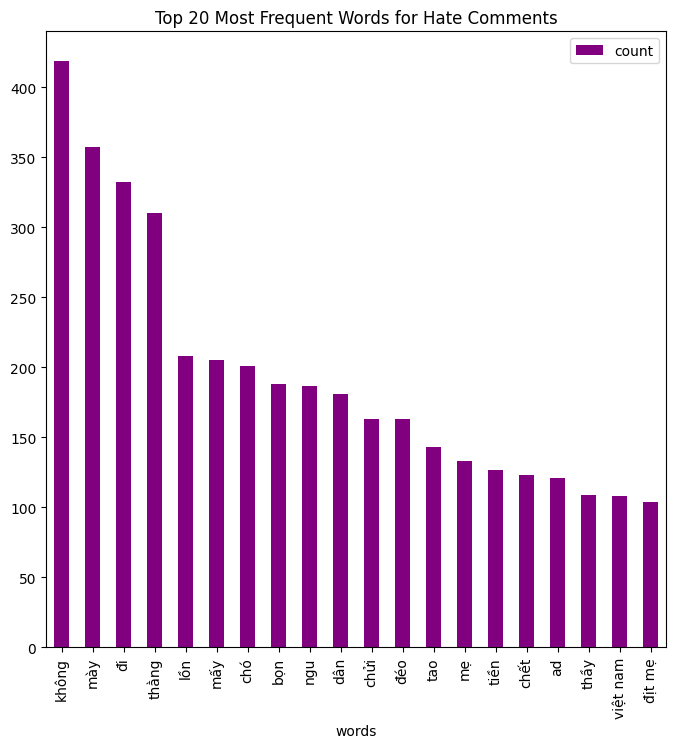

In [100]:
def wordcount_pandas(df, inputCol = 'bigrams', outputCol = 'bigrams', top_num = 10):
    from pyspark.sql.functions import explode, desc
    count_df = df.select(explode(inputCol).alias(outputCol)).groupBy(outputCol).count().sort(desc("count")).toPandas().iloc[0:top_num]

    return count_df
def wordcount(df, inputCol = 'bigrams', top_num = 10):

    #set up the count vectorizer
    count_vec = CountVectorizer().setInputCol(inputCol).setOutputCol('countVec')\
    .setVocabSize(500).setMinTF(1).setMinDF(1)
    count_fit = count_vec.fit(df)
    combined_df = count_fit.transform(df)

    #Get the combined dataframe which allows us to see the most common n-grams
    combined_df = (df.select(fn.explode(inputCol).alias('col')).select(
        fn.collect_list('col').alias(inputCol)))

    #fit the coutner so we can get the
    counts = count_fit.transform(combined_df).select('countVec').collect()

    count_dict = dict(zip(count_fit.vocabulary, counts[0]['countVec'].values))

    dict_counts = Counter(count_dict)
    top_words = dict_counts.most_common(top_num)

    return top_words
def plot_wordcount(df, inputCol = 'bigrams', outputCol = 'bigrams', top_num = 10, type_tweet = "Hate", color = 'purple'):
    from pyspark.sql.functions import explode, desc
    count_df = df.select(explode(inputCol).alias(outputCol)).groupBy(outputCol).count().sort(desc("count")).toPandas().iloc[0:top_num]

    fig, ax = plt.subplots(figsize=(8, 8))
    count_df.plot.bar(x = outputCol, y = 'count', ax = ax, color = color)
    ax.set_title("Top " + str(top_num) + " Most Frequent " + outputCol.capitalize() + " for " + type_tweet + " Comments")
    plt.show()
plot_wordcount(hate_tweets,inputCol = 'tokens_clean', outputCol = 'words', top_num = 20)

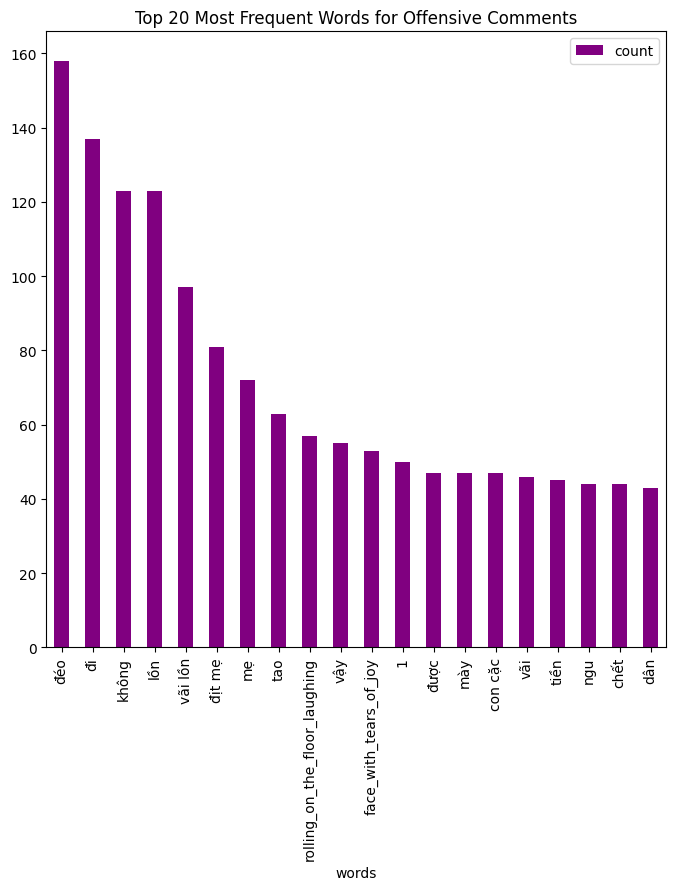

In [101]:
plot_wordcount(offensive_tweets,inputCol = 'tokens_clean', outputCol = 'words', top_num = 20,type_tweet = "Offensive")


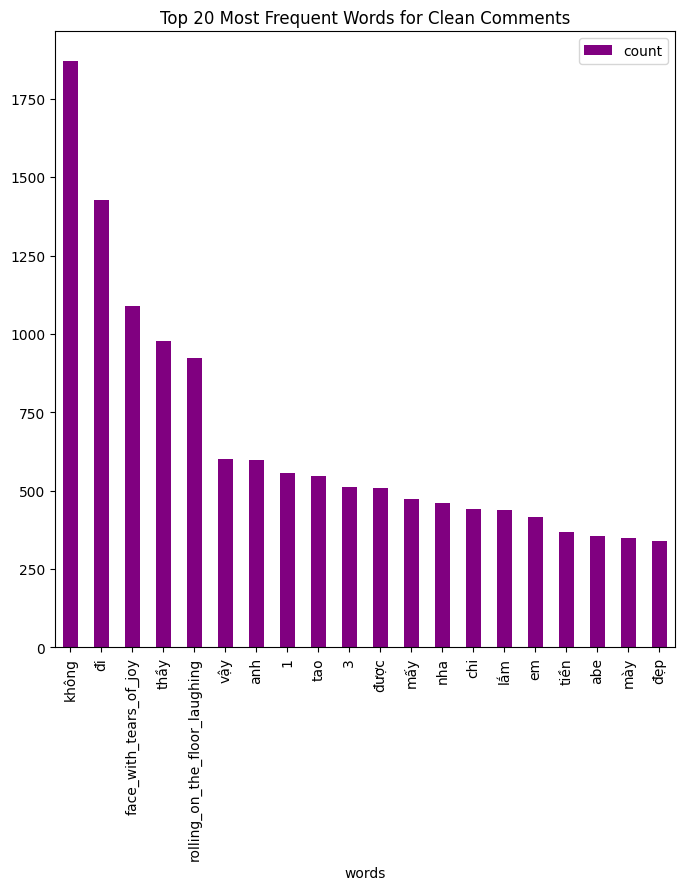

In [102]:
plot_wordcount(clean_tweets,inputCol = 'tokens_clean', outputCol = 'words', top_num = 20,type_tweet = "Clean")

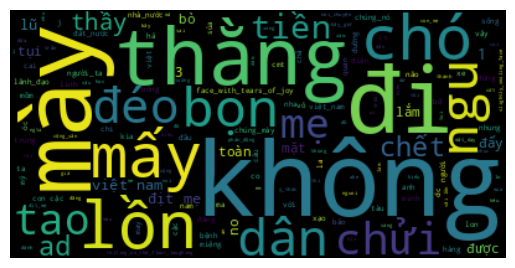

In [103]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate_from_frequencies(dict(wordcount(hate_tweets, inputCol = 'tokens_clean', top_num = 150)))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

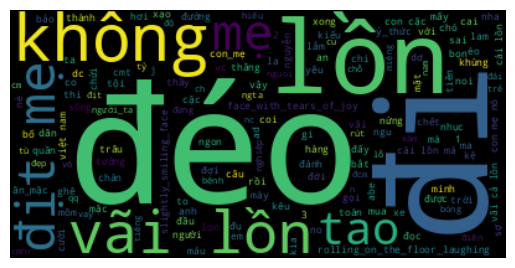

In [104]:
wordcloud = WordCloud().generate_from_frequencies(dict(wordcount(offensive_tweets, inputCol = 'tokens_clean', top_num = 150)))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

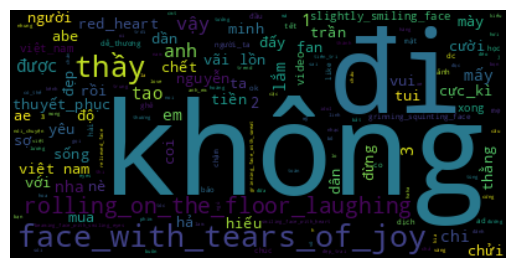

In [105]:
wordcloud = WordCloud().generate_from_frequencies(dict(wordcount(clean_tweets, inputCol = 'tokens_clean', top_num = 150)))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [106]:
from pyspark.ml.feature import Tokenizer, CountVectorizer
from pyspark.ml import Pipeline


vectorizer = CountVectorizer(inputCol="tokens_clean", outputCol="features")  # Adjust vocabSize as needed

pipeline = Pipeline(stages=[ vectorizer])

# Fit the pipeline to your data
tmd = pipeline.fit(train_df_cleaned)

# Get the vocabulary
vocab = tmd.stages[-1].vocabulary

# Print the vocabulary size
vocab_size = len(vocab)
print("Vocabulary Size:", vocab_size)


Vocabulary Size: 18442


In [107]:
from pyspark.sql.functions import expr

# Calculate the length of each element in the 'tokens_clean' array
gram_df = gram_df.withColumn("sequence_length", expr("size(tokens_clean)"))

# Get summary statistics of sequence lengths
summary_stats = gram_df.select("sequence_length").summary()
max_length = int(summary_stats.filter(summary_stats["summary"] == "max").select("sequence_length").collect()[0]["sequence_length"])

print("Max Sequence Length:", max_length)


Max Sequence Length: 128


In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.optim import lr_scheduler

vocabulary_size = 20000
sequence_length = 200
embedding_dim = 300
hidden_size = 64
output_size = 3
batch_size = 256
epochs = 40
drop = 0.5

# Convert Spark DataFrame to Pandas DataFrame for PyTorch processing
pandas_df = train_df_cleaned.select("tokens_clean", "label_id").toPandas()



In [109]:
def preprocess(spark, df_path):
    # Read the DataFrame from a CSV file
    df = spark.read.csv(df_path, header=True, inferSchema=True)

    # Define the deEmojify function using a UDF
    def deEmojify(text):
        return emoji.demojize(str(text))

    # Register the UDF
    deEmojify_udf = udf(deEmojify, StringType())

    # Apply the UDF to the 'free_text' column
    df = df.withColumn('free_text', deEmojify_udf('free_text'))

    # Define the clean_space function using a UDF
    def clean_space(text):
        if text is None or text.isspace():
            return None
        else:
            return text.strip()

    # Register the UDF
    clean_text_udf = udf(clean_space, StringType())

    # Apply the UDF to create a new column 'cleaned_text'
    df = df.withColumn("cleaned_text", clean_text_udf(col("free_text")))
    df = df.dropna(subset=["cleaned_text"])
    # Define the tokenize_with_pyvi function using a UDF
    def tokenize_with_pyvi(text):
        from pyvi import ViTokenizer
        return ViTokenizer.tokenize(text).split()

    # Register the UDF
    tokenize_udf = udf(tokenize_with_pyvi, ArrayType(StringType()))

    # Apply the UDF to the 'free_text' column
    df = df.withColumn("tokens", tokenize_udf("free_text"))

    # Convert tokens to lowercase
    df = df.withColumn("tokens_lower", udf(lambda tokens: [token.lower() for token in tokens], ArrayType(StringType()))("tokens"))

    # Remove punctuation from tokens
    df = df.withColumn("tokens_no_punctuation", udf(lambda tokens: [token.strip(".,") for token in tokens], ArrayType(StringType()))("tokens_lower"))

    # Remove special characters from tokens
    def remove_special_characters(tokens):
        return [token.replace(':', '').replace('=', '').replace('[', '').replace(']', '').replace(',', '').replace(';', '').replace(')', '').replace('(', '') for token in tokens]

    remove_special_characters_udf = udf(remove_special_characters, ArrayType(StringType()))
    df = df.withColumn("tokens_no_special", remove_special_characters_udf("tokens_no_punctuation"))

    # Keep only tokens with alphanumeric characters or underscore
    def keep_special_tokens(tokens):
        return [token for token in tokens if any(char.isalnum() or char == '_' for char in token)]

    keep_special_tokens_udf = udf(keep_special_tokens, ArrayType(StringType()))
    df = df.withColumn("tokens_cleaned", keep_special_tokens_udf("tokens_no_special"))


    # Define the replace_abbreviations function using a UDF
    def replace_abbreviations(tokens):
        result = []
        for token in tokens:
            for full_word, abbreviations in abbreviations_dict.items():
                if token in abbreviations:
                    result.append(full_word)
                    break
            else:
                result.append(token)
        return result
     # Define the stop words removal
    STOPWORDS = 'vietnamese-stopwords.txt'
    with open(STOPWORDS, "r") as ins:
        stopwords = []
        for line in ins:
            dd = line.strip('\n')
            stopwords.append(dd)

    stops = StopWordsRemover().setStopWords(stopwords).setInputCol('tokens_cleaned')\
        .setOutputCol('processed_tokens')
    df = stops.transform(df)


    abbreviations_dict = {
    'rồi': ['r'],
    'bạn': ['b'],
    'sao': ['s'],
    'được': ['đc'],
    'đéo': ['đ'],
    'không': ['k', 'ko', 'kh', 'kg'],
    'vãi lồn': ['vl', 'vlol'],
    'lồn': ['l', 'lol', 'lz'],
    'cái lồn má': ['clm'],
    'cặc': ['c'],
    'con cặc': ['cc'],
    'cái lồn': ['cl'],
    'vãi cả lồn': ['vcl'],
    'vãi cả cặc': ['vcc'],
    'mày': ['m'],
    "địt mẹ": ['dm', 'đm', 'đme', 'duma'],
    'anh': ['a'],
    'việt nam': ['vn', 'vnam'],
    'vậy': ['v'],
    'em': ['e'],
    'tao': ['t'],
    'con mẹ nó': ['cmn'],
    'người': ['ng'],
    'với': ['vs']
}

    replace_abbreviations_udf = udf(replace_abbreviations, ArrayType(StringType()))
    df = df.withColumn("tokens_clean", replace_abbreviations_udf("processed_tokens"))



    return df


In [110]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import seaborn as sns
X_test = preprocess(spark, "data/room_1/test.csv")
X_test_pandas = X_test.select("label_id","tokens_clean").toPandas()
X_test_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6691 entries, 0 to 6690
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label_id      6680 non-null   object
 1   tokens_clean  6691 non-null   object
dtypes: object(2)
memory usage: 104.7+ KB


In [111]:
y_test = X_test_pandas['label_id']
y_test

0       0
1       1
2       0
3       0
4       1
       ..
6686    0
6687    0
6688    0
6689    0
6690    0
Name: label_id, Length: 6691, dtype: object

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

lstm_units = 100
num_epochs = 10
max_length = 200
vocabulary_size = 20000
sequence_length = 200
embedding_dim = 300
hidden_size = 64
output_size = 3
batch_size = 256
epochs = 40
drop = 0.5

# Prepare data
X = pandas_df['tokens_clean']
y = pandas_df['label_id']